Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, Input, layers, losses, optimizers, datasets
from matplotlib import pyplot as plt

(X, Y), (Xtest, Ytest) = datasets.mnist.load_data()
X = X.astype(np.float32) / 255.0
Xtest = Xtest.astype(np.float32) / 255.0
X = X.reshape(-1, 28*28)
Xtest = Xtest.reshape(-1, 28*28)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# 784-392-196-98-196-392-784
inputs=Input(shape=X.shape[1])

en1=layers.Dense(X.shape[1]//2,activation='relu')
en2=layers.Dense(X.shape[1]//4,activation='relu')
en3=layers.Dense(X.shape[1]//8,activation='relu')

de1=layers.Dense(X.shape[1]//4,activation='relu')
de2=layers.Dense(X.shape[1]//2,activation='relu')
de3=layers.Dense(X.shape[1],activation='relu')

outputs=de3(de2(de1(en3(en2(en1(inputs))))))
model=Model(inputs,outputs)
model.compile(loss=losses.MeanSquaredError(),
              optimizer=optimizers.SGD(learning_rate=0.1))
model.fit(X,X,epochs=200)

In [3]:
import pickle

In [4]:
with open('model_ende_mnist', 'wb') as f:
  pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://88b09bcd-e66d-4e6d-86c3-d8374050d38c/assets


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
Xencoded = en3(en2(en1(X))).numpy()
print(Xencoded.shape)
clf1 = SVC()
clf1.fit(Xencoded, Y)
Xtestencoded = en3(en2(en1(Xtest))).numpy()
Z1 = clf1.predict(Xtestencoded)
print('accuracy rate=', accuracy_score(Ytest, Z1))
print('confusion matrix:')
print(confusion_matrix(Ytest, Z1))

(60000, 98)
accuracy rate= 0.9492
confusion matrix:
[[ 966    0    2    2    0    6    2    1    1    0]
 [   0 1122    3    2    0    2    3    0    3    0]
 [   9    0  973    8    9    2    8   10   12    1]
 [   2    0   11  952    1   15    1    9   16    3]
 [   1    0    7    0  936    0    9    2    3   24]
 [   8    2    4   24    7  821   10    2    9    5]
 [  11    3    4    1    5    7  924    1    2    0]
 [   0   11   19    5   11    0    0  961    5   16]
 [   4    3    4   10    9   19    7    8  907    3]
 [   4    6    2   13   30    3    1   13    7  930]]


In [8]:
Xtestencoded=en3(en2(en1(Xtest))).numpy()

In [9]:
Recon=de3(de2(de1(Xtestencoded))).numpy()

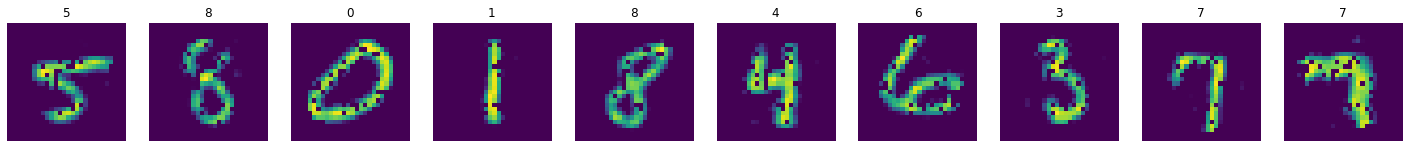

In [12]:
n = 10
plt.figure(figsize=(25,25))
for j,i in enumerate(np.random.randint(0,len(Recon),n)):
  plt.subplot(1,n,j+1)
  plt.imshow(Recon[i].reshape(28, 28))
  plt.title(Ytest[i])
  plt.axis('off')
plt.show()

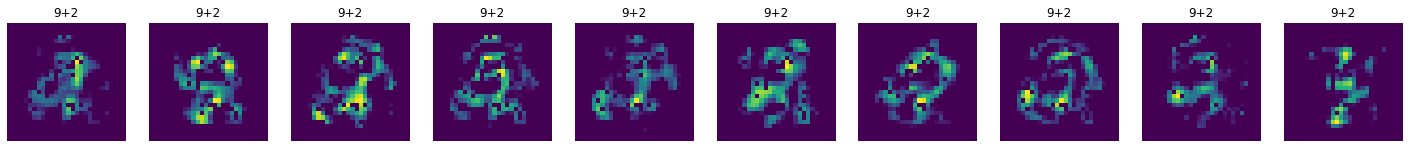

In [17]:
p=[9,2]
p1=np.where(Ytest==p[0])[0]
p2=np.where(Ytest==p[1])[0]
n=10
plt.figure(figsize=(25,25))
for i in range(n):
  temp=Xtestencoded[[np.random.choice(p1),np.random.choice(p2)]]
  x=np.hstack((temp[0,:temp.shape[1]//2],
                 temp[1,temp.shape[1]//2:])).reshape(1,temp.shape[1])
  Recon=de3(de2(de1(x))).numpy()
  Recon=Recon.reshape((len(Recon),28,28))[0]
  plt.subplot(1,n,i+1)
  plt.imshow(Recon)
  plt.title(str(p[0])+'+'+str(p[1]))
  plt.axis('off')
plt.show()

Autoenocoder with CNN

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, Input, layers, losses, optimizers, datasets
from matplotlib import pyplot as plt

(X, Y), (Xtest, Ytest) = datasets.mnist.load_data()

X = X.astype(np.float32) / 255.0
Xtest = Xtest.astype(np.float32) / 255.0

In [19]:
inputs = Input(shape=(*X.shape[1:], 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inputs, encoded, name='encoder')

encoded_inputs = Input(shape=encoded.shape[1:])
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_inputs)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded_inputs, decoded, name='decoder')

model = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
model.compile(optimizer='sgd', loss='mse')

In [20]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 8)           1904      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         2481      
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X[:,:,:,None], X[:,:,:,None], epochs=50)

Epoch 1/50
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0981
Epoch 2/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0597
Epoch 3/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0514
Epoch 4/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0474
Epoch 5/50
1875/1875 [==============================] - 72s 39ms/step - loss: 0.0445
Epoch 6/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0424
Epoch 7/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0407
Epoch 8/50
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0393
Epoch 9/50
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0382
Epoch 10/50
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0372
Epoch 11/50
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0363
Epoch 12/50
1875/1875 [==============================] - 71s 38

In [22]:
with open('model_endeCNN_mnist', 'wb') as f:
  pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://6b6a7602-0752-44a9-bbf3-eca9a9ca6b8a/assets


In [ ]:
with open('model_endeCNN_mnist', 'rb') as f:
  model = pickle.load(f)

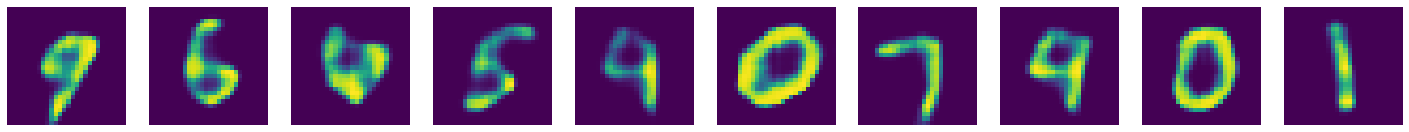

In [23]:
Z = model(Xtest)
n = 10
plt.figure(figsize=(25, 25))
for i in range(10):
  plt.subplot(1, n, i+1)
  plt.imshow(Z[i+20][:,:,0])
  plt.axis('off')
plt.show()

Denoising

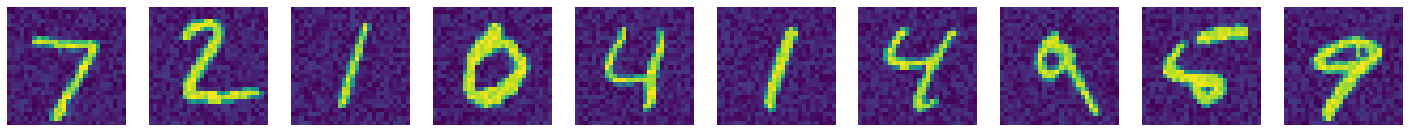

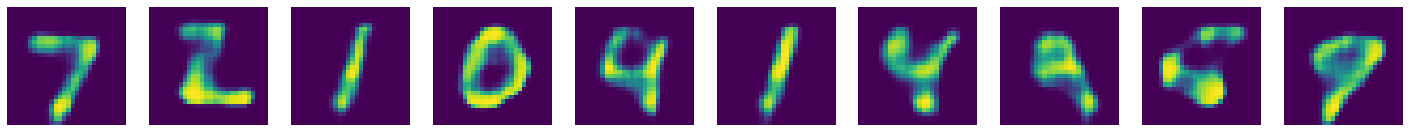

In [24]:
Xnoise = Xtest + 0.2 * np.random.rand(*Xtest.shape)
Xnoise /= Xnoise.max()
Z = model(Xnoise)
n = 10
plt.figure(figsize=(25, 25))
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.imshow(Xnoise[i])
  plt.axis('off')
plt.show()

plt.figure(figsize=(25, 25))
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.imshow(Z[i][:,:,0])
  plt.axis('off')
plt.show()